# BiGSLICE GCF analysis

This notebook analyses the GCFs predicted using BiGSLICE and reannotated them based on the known clusterblast matches for the known BGCs.

In [1]:
import os
import pandas as pd
import sqlite3
import yaml
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import plot, UpSet

In [2]:
with open("config.yaml", "r") as f:
    notebook_configuration = yaml.safe_load(f)
notebook_configuration

{'bgcflow_dir': '/datadrive/bgcflow'}

In [4]:
bgcflow_dir = Path(notebook_configuration["bgcflow_dir"])
project_name_1 = "mq_strepto"
processed_dir_1 = bgcflow_dir / "data" / "processed" / project_name_1

## Extract tables from SQL database and save as CSV

The SQL database from bigslice rule was processed to generate dataframes below. This step is required only one time.

In [9]:
# Read output tables from the processed directory
ncbi_meta_table = processed_dir_1 / "tables"/ "df_ncbi_meta.csv"
df_ncbi_meta = pd.read_csv(ncbi_meta_table, index_col= 0)

gtdb_meta_table = processed_dir_1 / "tables"/ "df_gtdb_meta_curated.csv"
df_gtdb_meta = pd.read_csv(gtdb_meta_table, index_col= 0)

seqfu_meta_table = processed_dir_1 / "tables"/ "df_seqfu_stats.csv"
df_seqfu_meta = pd.read_csv(seqfu_meta_table, index_col= 0)

mash_table = processed_dir_1 / "mash"/ "df_mash.csv"
df_mash = pd.read_csv(mash_table, index_col= 0)

df_clusters = pd.read_csv("assets/tables/df_clusters.csv", index_col=0)
df_subcluster = pd.read_csv("assets/tables/df_subclusters_reduced.csv", index_col=0)

filters_table = processed_dir_1 / "tables" / "df_filters.csv"
df_filter_quality = pd.read_csv(filters_table, index_col=0)

antismash_summary_table = processed_dir_1 / "tables" / "df_antismash_7.0.0_summary.csv"
df_antismash_summary = pd.read_csv(antismash_summary_table, index_col=0, low_memory=False)

bgcs_summary_table = processed_dir_1 / "tables" / "df_regions_antismash_7.0.0.csv"
df_bgcs_antismash = pd.read_csv(bgcs_summary_table, index_col=0)

arts_table = processed_dir_1 / "tables" / "df_arts_as-7.0.0.csv"
df_arts = pd.read_csv(arts_table, index_col=0)

In [6]:
data_db_file = processed_dir_1 / "bigslice/cluster_as_7.0.0/result/data.db"

with sqlite3.connect(data_db_file) as conn:
    # get all table name from sql
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    sql_table_names = [i[0] for i in cursor.fetchall()]

# convert table to pandas df
df_tables = {}
for t in sql_table_names:
    df = pd.read_sql_query(f"select * from {t};", conn)
    df_tables.update({t: df})

df_bgcs = df_tables["bgc"]
df_gcfs = df_tables["gcf"]
df_gcf_membership = df_tables["gcf_membership"]

df_gcfs = df_gcfs[df_gcfs.clustering_id==2]
df_gcf_membership = df_gcf_membership[df_gcf_membership["gcf_id"] != 1]

df_bgcs.to_csv("/datadrive/bgcflow/data/processed/mq_strepto/bigslice/cluster_as_7.0.0/df_bgcs.csv")
df_gcfs.to_csv("/datadrive/bgcflow/data/processed/mq_strepto/bigslice/cluster_as_7.0.0/df_gcfs.csv")
df_gcf_membership.to_csv("/datadrive/bgcflow/data/processed/mq_strepto/bigslice/cluster_as_7.0.0/df_gcf_membership.csv")

In [61]:
for idx in df_bgcs_bigslice.index:
    genome_id = df_bgcs_bigslice.loc[idx, "orig_folder"]
    bgc_file = df_bgcs_bigslice.loc[idx, "orig_filename"]
    bgc_id = bgc_file[:-4]
    if bgc_id in df_bgcs_antismash.index:
        df_bgcs_bigslice.loc[idx, "bgc_id"] = bgc_id
    else:
        print(bgc_file)
    df_bgcs_bigslice.loc[idx, "genome_id"] = genome_id

df_bgcs_bigslice = df_bgcs_bigslice.set_index("id")

In [62]:
for idx in df_gcf_membership.index:
    bgc_id = df_gcf_membership.loc[idx, "bgc_id"]
    gcf_id = df_gcf_membership.loc[idx, "gcf_id"]
    membership_value = df_gcf_membership.loc[idx, "membership_value"]

    df_bgcs_bigslice.loc[bgc_id, "gcf_id"] = str(gcf_id)
    df_bgcs_bigslice.loc[bgc_id, "membership_value"] = membership_value
df_bgcs_bigslice = df_bgcs_bigslice.set_index("bgc_id")

In [63]:
df_gcfs_bigslice["count"] = df_gcf_membership.gcf_id.value_counts()
df_gcfs_bigslice = df_gcfs_bigslice.sort_values(by="count", ascending=False)

In [64]:
df_gcfs_bigslice_large = df_gcfs_bigslice[df_gcfs_bigslice["count"] >= 10]

In [65]:
df_gcf_presence = pd.DataFrame(0, index=df_mash_cluster_all.index, columns=df_gcfs_bigslice.index)
for gcf_id in df_gcf_presence.columns:
    genome_list = df_bgcs_bigslice[df_bgcs_bigslice.gcf_id == str(gcf_id)].genome_id.tolist()
    for genome_id in genome_list:
        if genome_id in df_gcf_presence.index:
            df_gcf_presence.loc[genome_id, gcf_id] = df_gcf_presence.loc[genome_id, gcf_id] + 1

In [66]:
df_gcf_presence = df_gcf_presence.applymap(lambda x: 1 if x > 0 else 0)

# Annotate known GCFs based on known clusterblast similarity

In [68]:
df_bgcs_antismash_known = df_bgcs_antismash[df_bgcs_antismash.similarity > 0.8]

In [69]:
df_bgcs_bigslice["known_cluster_blast"] = "NA"
df_bgcs_bigslice["known_cluster_blast_name"] = "NA"
df_bgcs_bigslice.loc[df_bgcs_antismash_known.index, "known_cluster_blast"]= df_bgcs_antismash_known["most_similar_known_cluster_id"]
df_bgcs_bigslice.loc[df_bgcs_antismash_known.index, "most_similar_known_cluster_type"]= df_bgcs_antismash_known["most_similar_known_cluster_type"]
df_bgcs_bigslice.loc[df_bgcs_antismash_known.index, "known_cluster_blast_name"]= df_bgcs_antismash_known["most_similar_known_cluster_description"]

In [70]:
df_gcfs_bigslice["known_cluster_count"] = 0
df_gcfs_bigslice["known_clusters_id"] = "NA"
df_gcfs_bigslice["known_clusters_name"] = "NA"
df_gcfs_bigslice["known_clusters_type"] = "NA"
df_gcfs_bigslice["top_known_cluster_id"] = "NA"
df_gcfs_bigslice["top_known_cluster_name"] = "NA"
df_gcfs_bigslice["top_known_cluster_type"] = "NA"
df_gcfs_bigslice["top_known_cluster_category"] = "NA"

for gcf_id in df_gcfs_bigslice.index:
    df_bgcs_list = df_bgcs_bigslice[df_bgcs_bigslice.gcf_id == int(gcf_id)]
    known_bgcs_id = df_bgcs_list.known_cluster_blast.value_counts().index
    known_bgcs_id = [x for x in known_bgcs_id if x != "NA"]
    
    known_bgcs_name = df_bgcs_list.known_cluster_blast_name.value_counts().index
    known_bgcs_name = [x for x in known_bgcs_name if x != "NA"]

    known_bgcs_type = df_bgcs_list.most_similar_known_cluster_type.value_counts().index
    known_bgcs_type = [x for x in known_bgcs_type if x != "NA"]
    
    df_gcfs_bigslice.loc[gcf_id, "known_cluster_count"] = len(known_bgcs_id)
    df_gcfs_bigslice.loc[gcf_id, "known_clusters_id"] = ",".join(known_bgcs_id)
    df_gcfs_bigslice.loc[gcf_id, "known_clusters_name"] = ",".join(known_bgcs_name)
    df_gcfs_bigslice.loc[gcf_id, "known_clusters_type"] = ",".join(known_bgcs_type)

    if len(known_bgcs_id) >0:
        df_gcfs_bigslice.loc[gcf_id, "top_known_cluster_id"] = known_bgcs_id[0]
        df_gcfs_bigslice.loc[gcf_id, "top_known_cluster_name"] = known_bgcs_name[0]
        df_gcfs_bigslice.loc[gcf_id, "top_known_cluster_type"] = known_bgcs_type[0]
        if ":" in known_bgcs_type[0]:
            df_gcfs_bigslice.loc[gcf_id, "top_known_cluster_category"] = known_bgcs_type[0].split(":")[0]
        else:
            df_gcfs_bigslice.loc[gcf_id, "top_known_cluster_category"] = known_bgcs_type[0]

df_gcfs_bigslice["known"] = ["Unknown" if mibig == "NA" else "Known" for mibig in df_gcfs_bigslice.top_known_cluster_id]

# All GCFs of BiGSLICE distribution

/tmp/ipykernel_2163/4258439479.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Cluster_label.fillna("NA",inplace=True)


<Figure size 1500x1000 with 0 Axes>

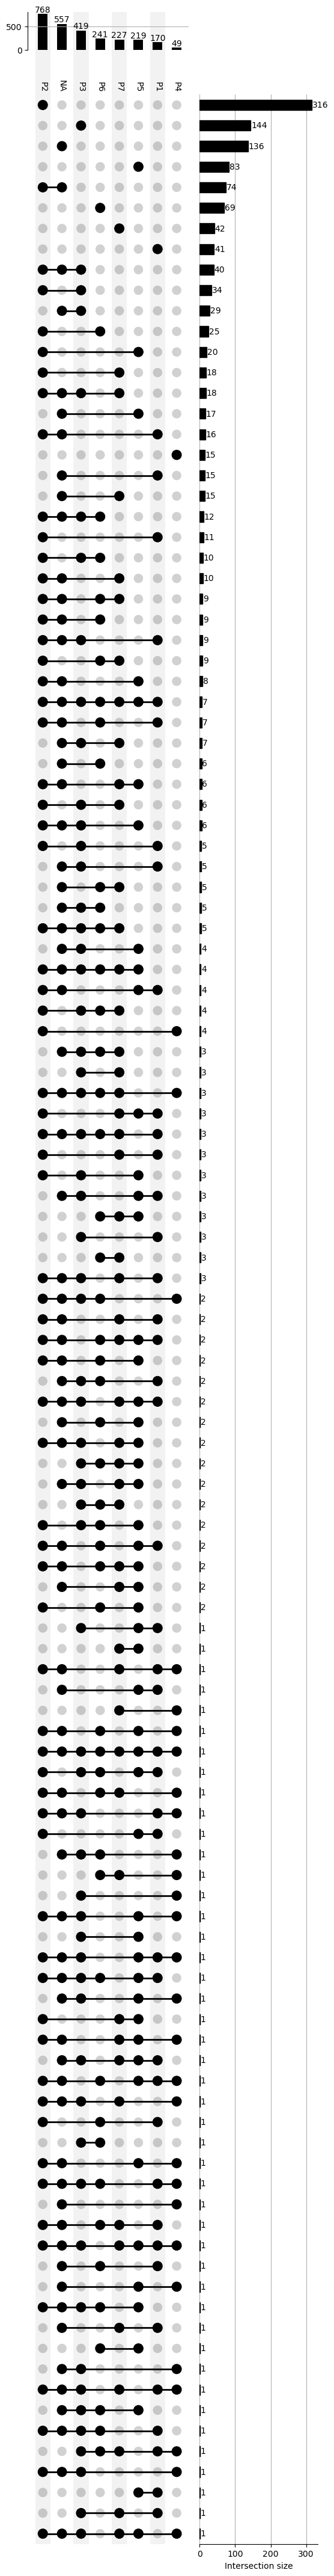

In [570]:
# Melt the dataframe
df_gcf_presence_tmp = df_gcf_presence.loc[:, df_gcfs_bigslice[df_gcfs_bigslice["count"] > 5].index]
df_gcf_presence_tmp["genome_id"] = df_gcf_presence_tmp.index
df1 = df_gcf_presence_tmp.melt(id_vars=["genome_id"], value_vars=df_gcf_presence_tmp.columns[:-1],
                               var_name="BGC",
                               value_name="presence")
df2 = df_clusters[["Cluster_label"]]
df2.Cluster_label.fillna("NA",inplace=True)
# Merging dataframes
df = df1.merge(df2, on='genome_id')

# Creating a pivot table
pivot_table = df.pivot_table(index='BGC', columns='Cluster_label', values='presence', aggfunc='sum').fillna(0)

df_binary = (pivot_table > 0).astype(int)

# Convert the wide DataFrame to a long one
df_long = df_binary.reset_index().melt(id_vars='BGC', value_name='presence')
# Filter out entries where presence is 0
df_long = df_long[df_long.presence == 1]

# Create a boolean matrix representation
df_bool = pd.crosstab(df_long['BGC'], df_long['Cluster_label'])

# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_bool.astype(bool)))

# Manually set the colors
plt.figure(figsize=(15, 10))

ax = plot(df_multi_index, subset_size='count', sort_by="cardinality", show_counts=True, orientation="vertical")
plt.savefig("assets/figures/upset_gcfs.svg")
plt.savefig("assets/figures/upset_gcfs.png")
plt.show()

## Common GCF spread across 6 or more phylogroups

<Figure size 1500x1000 with 0 Axes>

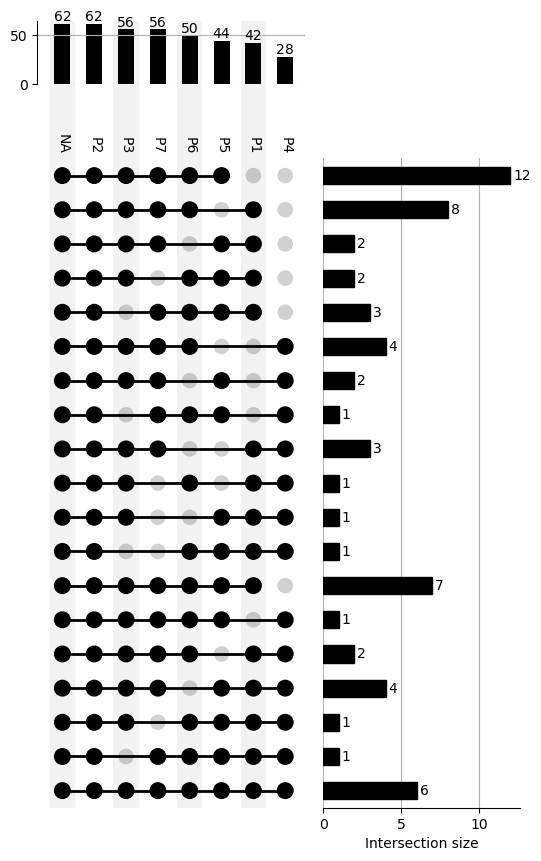

In [380]:
# Filter rows that are present in more than 6 groups
df_filtered = df_binary[df_binary.sum(axis=1) >= 6]

# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_filtered.astype(bool)))

# Manually set the colors
plt.figure(figsize=(15, 10))

ax = plot(df_multi_index, subset_size='count', show_counts=True, orientation="vertical")
plt.savefig("assets/figures/upset_gcfs_6_and_above.svg")
plt.savefig("assets/figures/upset_gcfs_6_and_above.png")
plt.show()

## Accessory GCFs present in 2 to 5 phylogroups (most significant intersections selected)

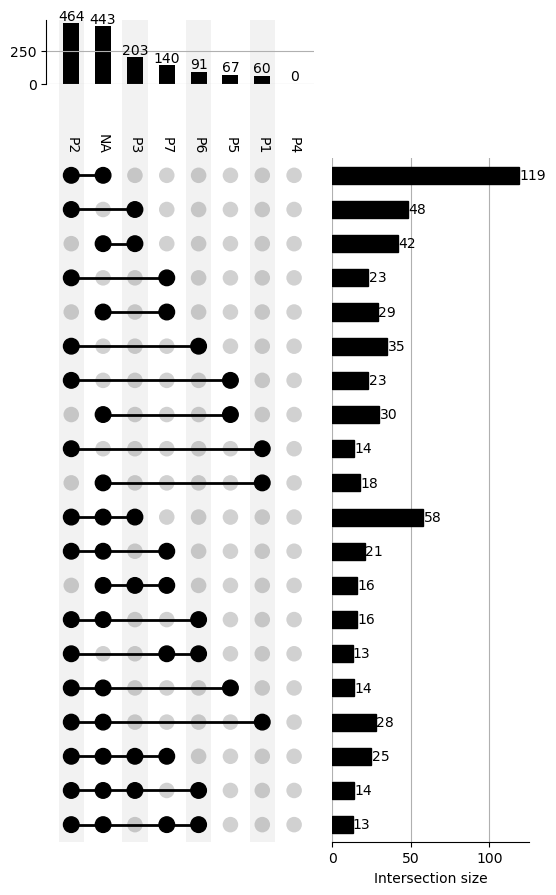

In [491]:
# Filter BGCs present in 2 to 6 groups and keep top n intersections 
df_filtered = df_binary[(df_binary.sum(axis=1) > 1) & (df_binary.sum(axis=1) < 6)]

# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_filtered.astype(bool)))

# Calculate the size of each intersection
intersection_counts = df_multi_index.groupby(level=list(range(df_multi_index.index.nlevels))).size()

# Sort by size and keep the top n intersections
n = 20
top_intersections = intersection_counts.nlargest(n).index

# Filter df_multi_index to only include top intersections
df_multi_index_filtered = df_multi_index[df_multi_index.index.isin(top_intersections)]

# This will sort by size of intersections and only show the top 10
ax = plot(df_multi_index_filtered, subset_size='count', show_counts=True, orientation="vertical")
plt.savefig("assets/figures/upset_gcfs_2_6.svg")
plt.savefig("assets/figures/upset_gcfs_2_6.png")
plt.show()

# Combining GCFs with antiSMASH knownclusterblast 

In [10]:
replace_known_dict = {"surugamide A/surugamide D": "surugamide",
                      "leupeptin Pr/leupeptin Ac": "leupeptin",
                      "diisonitrile antibiotic SF2768": "SF2768",
                      "isatropolone A/isotropolone B/isotropolone C": "isatropolone",
                      "montamide A/capsimycin/clifednamide A/frontalamide A/combamide A": "montamide",
                      "legonoxamine A/desferrioxamine B/legonoxamine B": "desferrioxamine",
                      "SGR PTMs/SGR PTM Compound b/SGR PTM Compound c/SGR PTM Compound d": "SGR PTM",
                      "5-dimethylallylindole-3-acetonitrile" : "5-DMAIAN",
                      "flaviolin/1,3,6,8-tetrahydroxynaphthalene": "flaviolin",
                     "rhizomide A/rhizomide B/rhizomide C": "rhizomide",
                     "10,11-dihydro-8-deoxy-12,13-deepoxy-12,13-dihydrochalcomycin": "dihydrochalcomycin",
                     "fuelimycin A/fuelimicin B/fuelimicin C": "fuelimycin",
                     "desferrioxamin B/desferrioxamine E": "desferrioxamine",
                     "desferrioxamin B": "desferrioxamine",
                     "desferrioxamine E": "desferrioxamine",
                     "linearmycin A/linearmycin B/linearmycin C/linearmycin C": "linearmycin",
                     "youssoufene A1/youssoufene B1/youssoufene B2/youssoufene B3/youssoufene B4": "youssoufene",
                     "maduralactomycin A/maduralactomycin B/actinospirol A/actinospirol B": "maduralactomycin",
                     "10-epi-HSAF/10-epi-3-deOH-HSAF/10-epi-maltophilin/10-epi-xanthobaccin C/10-epi-hydroxymaltophilin/10-epi-FI-2": "10-epi-HSAF",
                     "montamide A/capsimycin/clifednamide A/frontalamide A/combamide A": "montamide",
                     "divergolide A/divergolide B/divergolide C/divergolide D":"divergolide",
                     "detoxin P1/detoxin P2/detoxin P3":"detoxin",
                      "CDA1b/CDA2a/CDA2b/CDA3a/CDA3b/CDA4a/CDA4": "CDA",
                      "echoside A/echoside B/echoside C/echoside D/echoside E": "echoside",
                      "salinamide A/salinamide B/salinamide C/salinamide D/salinamide E/salinamide F/desmethylsalinamide C/desmethylsalinamide E": "salinamide",
                      "ilamycin B1/ilamycin B2/ilamycin C1/ilamycin C2/ilamycin D/ilamycin E1": "ilamycin",
                      "saccharothrixin D/saccharothrixin E/saccharothrixin F/saccharothrixin G/saccharothrixin H/saccharothrixin I/saccharothrixin J/saccharothrixin K/saccharothrixin L/saccharothrixin M": "saccharothrixin",
                      "rubiginone A2/rubiginone J/rubiginone K/rubiginone L/rubiginone M/rubiginone N/ochromycinone/rubiginone B2": "rubiginone",
                      }

In [78]:
df_gcfs_bigslice["gcf_combined"] = df_gcfs_bigslice.index
df_bgcs_bigslice["gcf_combined"] = [str(gcf_id) for gcf_id in df_bgcs_bigslice.gcf_id]
df_gcfs_bigslice["gcf_combined_id"] = df_gcfs_bigslice.index
df_bgcs_bigslice["gcf_combined_id"] = [str(gcf_id) for gcf_id in df_bgcs_bigslice.gcf_id]

list_curate = []
for gcf_id in df_gcfs_bigslice.index:
    if df_gcfs_bigslice.loc[gcf_id, "known"] == "Known":
        select_bgcs = df_bgcs_bigslice[df_bgcs_bigslice.gcf_id == int(gcf_id)].index
        known_bgc = df_gcfs_bigslice.loc[gcf_id, "top_known_cluster_name"]
        known_bgc_id = df_gcfs_bigslice.loc[gcf_id, "top_known_cluster_id"]
        known_bgc_cat = df_gcfs_bigslice.loc[gcf_id, "top_known_cluster_category"]
        
        df_gcfs_bigslice.loc[gcf_id, "gcf_combined_id"] = known_bgc_id
        df_bgcs_bigslice.loc[select_bgcs, "gcf_combined_id"] = known_bgc_id

        if known_bgc in replace_known_dict.keys():
            df_gcfs_bigslice.loc[gcf_id, "gcf_combined"] = replace_known_dict[known_bgc]
            df_bgcs_bigslice.loc[select_bgcs, "gcf_combined"] = replace_known_dict[known_bgc]
        else:
            df_gcfs_bigslice.loc[gcf_id, "gcf_combined"] = known_bgc
            df_bgcs_bigslice.loc[select_bgcs, "gcf_combined"] = known_bgc
            if len(known_bgc) > 15:
                if known_bgc not in list_curate:
                    list_curate.append(known_bgc)

In [118]:
df_gcfs_bigslice_combined = pd.DataFrame(index=df_gcfs_bigslice.gcf_combined_id.unique(), 
                                        columns=["bigslice_gcf_count", "bgc_count", "known", 
                            "known_cluster_count", "known_clusters_id", "top_known_cluster_id", 
                            "top_known_cluster_name", "top_known_cluster_category", 
                            "top_known_cluster_type", "gcf_combined_name", "gcf_combined_id"])
for gcf_combined_id in df_gcfs_bigslice_combined.index:
    df_gcfs_selected = df_gcfs_bigslice[df_gcfs_bigslice.gcf_combined_id == gcf_combined_id]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "bigslice_gcf_count"] = df_gcfs_selected.shape[0]
    
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "bgc_count"] = df_gcfs_selected["count"].sum()
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "known"] = df_gcfs_selected["known"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "top_known_cluster_id"] = df_gcfs_selected["top_known_cluster_id"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "top_known_cluster_name"] = df_gcfs_selected["top_known_cluster_name"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "top_known_cluster_category"] = df_gcfs_selected["top_known_cluster_category"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "top_known_cluster_type"] = df_gcfs_selected["top_known_cluster_type"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "gcf_combined_name"] = df_gcfs_selected["gcf_combined"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "gcf_combined_id"] = df_gcfs_selected["gcf_combined_id"].unique()[0]
    
    known_clusters_id_str = ",".join(df_gcfs_selected["known_clusters_id"].unique())
    known_clusters_id_list = set(known_clusters_id_str.split(","))
    known_clusters_id = ",".join(known_clusters_id_list)
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "known_clusters_id"] = known_clusters_id
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "known_cluster_count"] = len(known_clusters_id_list)
    
df_gcfs_bigslice_combined.sort_values(by="bgc_count", ascending=False, inplace=True)    

# Combine different MIBIG entries coding for similar compounds
gcf_combined_name_counts = df_gcfs_bigslice_combined.gcf_combined_name.value_counts()
replace_mibig_list = gcf_combined_name_counts[gcf_combined_name_counts > 1].index.tolist()

for mibig_name in replace_mibig_list:
    df_gcfs_bigslice_combined_selected = df_gcfs_bigslice_combined[df_gcfs_bigslice_combined.gcf_combined_name == mibig_name]
    df_gcfs_bigslice_selected = df_gcfs_bigslice[df_gcfs_bigslice.gcf_combined == mibig_name]
    df_bgcs_bigslice_selected = df_bgcs_bigslice[df_bgcs_bigslice.gcf_combined == mibig_name]

    selected_gcf_id = df_gcfs_bigslice_combined_selected.gcf_combined_id[0]
    df_bgcs_bigslice.loc[df_bgcs_bigslice_selected.index, "gcf_combined_id"] = selected_gcf_id
    df_gcfs_bigslice.loc[df_gcfs_bigslice_selected.index, "gcf_combined_id"] = selected_gcf_id

df_gcfs_bigslice_combined = pd.DataFrame(index=df_gcfs_bigslice.gcf_combined_id.unique(), 
                                        columns=["bigslice_gcf_count", "bgc_count", "known", 
                            "known_cluster_count", "known_clusters_id", "top_known_cluster_id", 
                            "top_known_cluster_name", "gcf_combined_name", "gcf_combined_id"])
for gcf_combined_id in df_gcfs_bigslice_combined.index:
    df_gcfs_selected = df_gcfs_bigslice[df_gcfs_bigslice.gcf_combined_id == gcf_combined_id]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "bigslice_gcf_count"] = df_gcfs_selected.shape[0]
    
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "bgc_count"] = df_gcfs_selected["count"].sum()
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "known"] = df_gcfs_selected["known"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "top_known_cluster_id"] = df_gcfs_selected["top_known_cluster_id"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "top_known_cluster_name"] = df_gcfs_selected["top_known_cluster_name"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "top_known_cluster_category"] = df_gcfs_selected["top_known_cluster_category"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "top_known_cluster_type"] = df_gcfs_selected["top_known_cluster_type"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "gcf_combined_name"] = df_gcfs_selected["gcf_combined"].unique()[0]
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "gcf_combined_id"] = df_gcfs_selected["gcf_combined_id"].unique()[0]
    
    known_clusters_id_str = ",".join(df_gcfs_selected["known_clusters_id"].unique())
    known_clusters_id_list = set(known_clusters_id_str.split(","))
    known_clusters_id = ",".join(known_clusters_id_list)
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "known_clusters_id"] = known_clusters_id
    df_gcfs_bigslice_combined.loc[gcf_combined_id, "known_cluster_count"] = len(known_clusters_id_list)
    
df_gcfs_bigslice_combined.sort_values(by="bgc_count", ascending=False, inplace=True)    

In [82]:
df_gcf_presence_combined_all = pd.DataFrame(0, index=df_clusters.index, columns=df_gcfs_bigslice_combined.index)
for gcf_id in df_gcf_presence_combined_all.columns:
    genome_list = df_bgcs_bigslice[df_bgcs_bigslice.gcf_combined_id == str(gcf_id)].genome_id.tolist()
    for genome_id in genome_list:
        if genome_id in df_gcf_presence_combined_all.index:
            df_gcf_presence_combined_all.loc[genome_id, gcf_id] = df_gcf_presence_combined_all.loc[genome_id, gcf_id] + 1

In [83]:
df_gcf_presence_combined_all.to_csv(processed_dir_1 / "bigslice" / "cluster_as_7.0.0" / "df_gcf_presence_combined.csv")
df_gcfs_bigslice.to_csv(processed_dir_1 / "bigslice" / "cluster_as_7.0.0" / "df_gcfs_curated_with_combined.csv")
df_gcfs_bigslice_combined.to_csv(processed_dir_1 / "bigslice" / "cluster_as_7.0.0" / "df_gcfs_combined.csv") 
df_bgcs_bigslice.to_csv(processed_dir_1 / "bigslice" / "cluster_as_7.0.0" / "df_bgcs_curated_with_combined.csv")

In [159]:
df_gcfs_bigslice_combined_known = df_gcfs_bigslice_combined[df_gcfs_bigslice_combined.known == "Known"]
df_gcf_presence_combined = df_gcf_presence_combined_all.loc[df_clusters.index, df_gcfs_bigslice_combined_known.index]

/tmp/ipykernel_84879/3410909953.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Cluster_label.fillna("NA",inplace=True)


<Figure size 1500x1000 with 0 Axes>

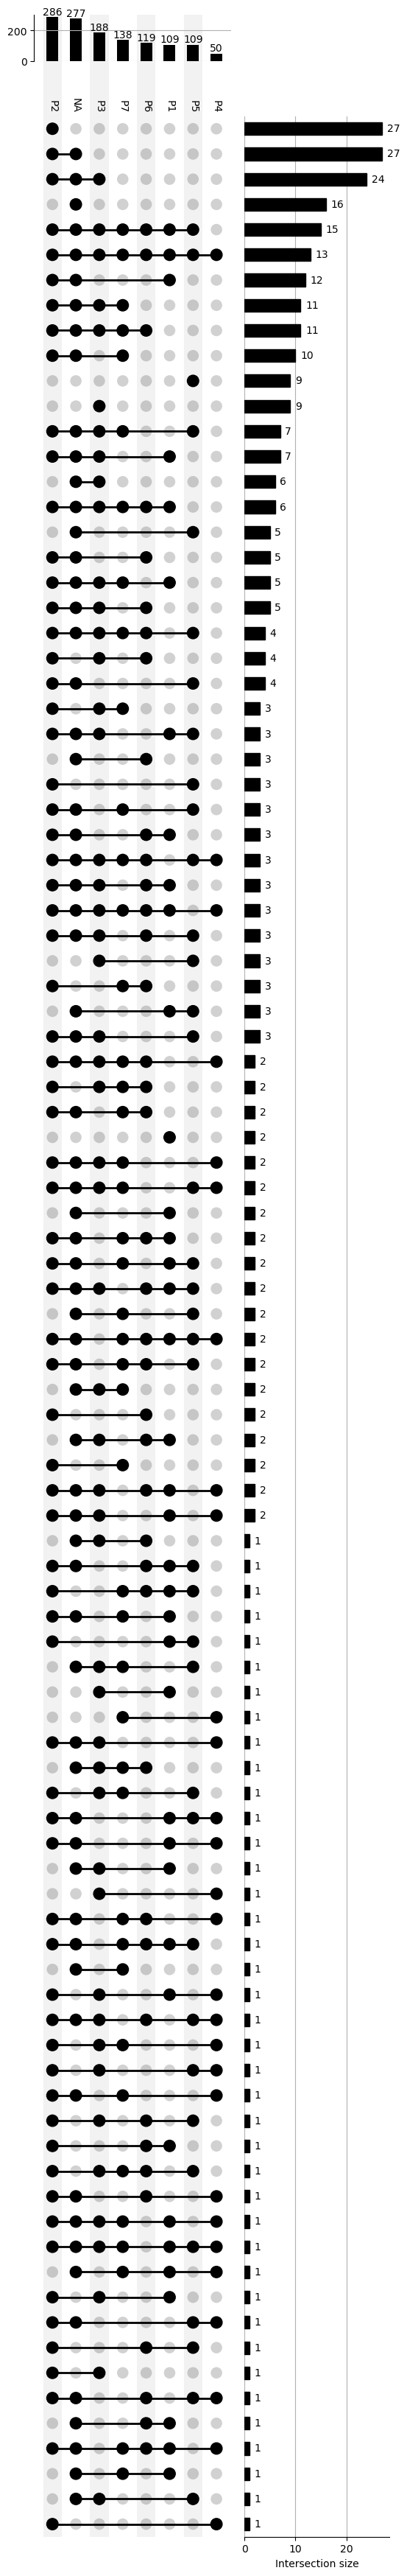

In [160]:
# Melt the dataframe
df_gcf_presence_tmp = df_gcf_presence_combined.loc[:, df_gcfs_bigslice_combined_known[df_gcfs_bigslice_combined_known["bgc_count"] > 5].index]
df_gcf_presence_tmp["genome_id"] = df_gcf_presence_tmp.index
df1 = df_gcf_presence_tmp.melt(id_vars=["genome_id"], value_vars=df_gcf_presence_tmp.columns[:-1],
                               var_name="BGC",
                               value_name="presence")
df2 = df_clusters[["Cluster_label"]]
df2.Cluster_label.fillna("NA",inplace=True)
# Merging dataframes
df = df1.merge(df2, on='genome_id')

# Creating a pivot table
pivot_table = df.pivot_table(index='BGC', columns='Cluster_label', values='presence', aggfunc='sum').fillna(0)

df_binary = (pivot_table > 0).astype(int)

# Convert the wide DataFrame to a long one
df_long = df_binary.reset_index().melt(id_vars='BGC', value_name='presence')
# Filter out entries where presence is 0
df_long = df_long[df_long.presence == 1]

# Create a boolean matrix representation
df_bool = pd.crosstab(df_long['BGC'], df_long['Cluster_label'])

# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_bool.astype(bool)))

# Manually set the colors
plt.figure(figsize=(15, 10))

ax = plot(df_multi_index, subset_size='count', sort_by="cardinality", show_counts=True, orientation="vertical")
# plt.savefig("assets/figures/upset_gcfs.svg")
# plt.savefig("assets/figures/upset_gcfs.png")
plt.show()

## Common GCF spread across 6 or more phylogroups

<Figure size 1500x1000 with 0 Axes>

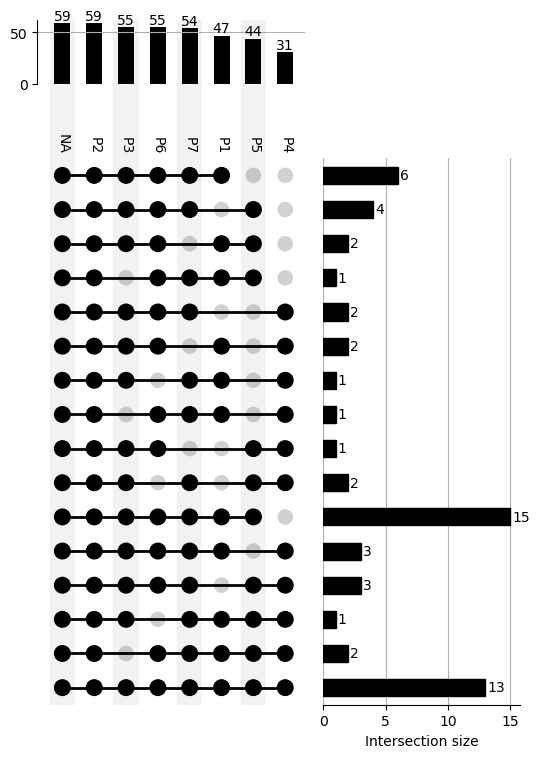

In [161]:
# Filter rows that are present in more than 6 groups
df_filtered = df_binary[df_binary.sum(axis=1) >= 6]


# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_filtered.astype(bool)))

# Manually set the colors
plt.figure(figsize=(15, 10))

ax = plot(df_multi_index, subset_size='count', show_counts=True, orientation="vertical")
# plt.savefig("assets/figures/upset_gcfs_6_and_above.svg")
# plt.savefig("assets/figures/upset_gcfs_6_and_above.png")
plt.show()

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


<Figure size 2000x4000 with 0 Axes>

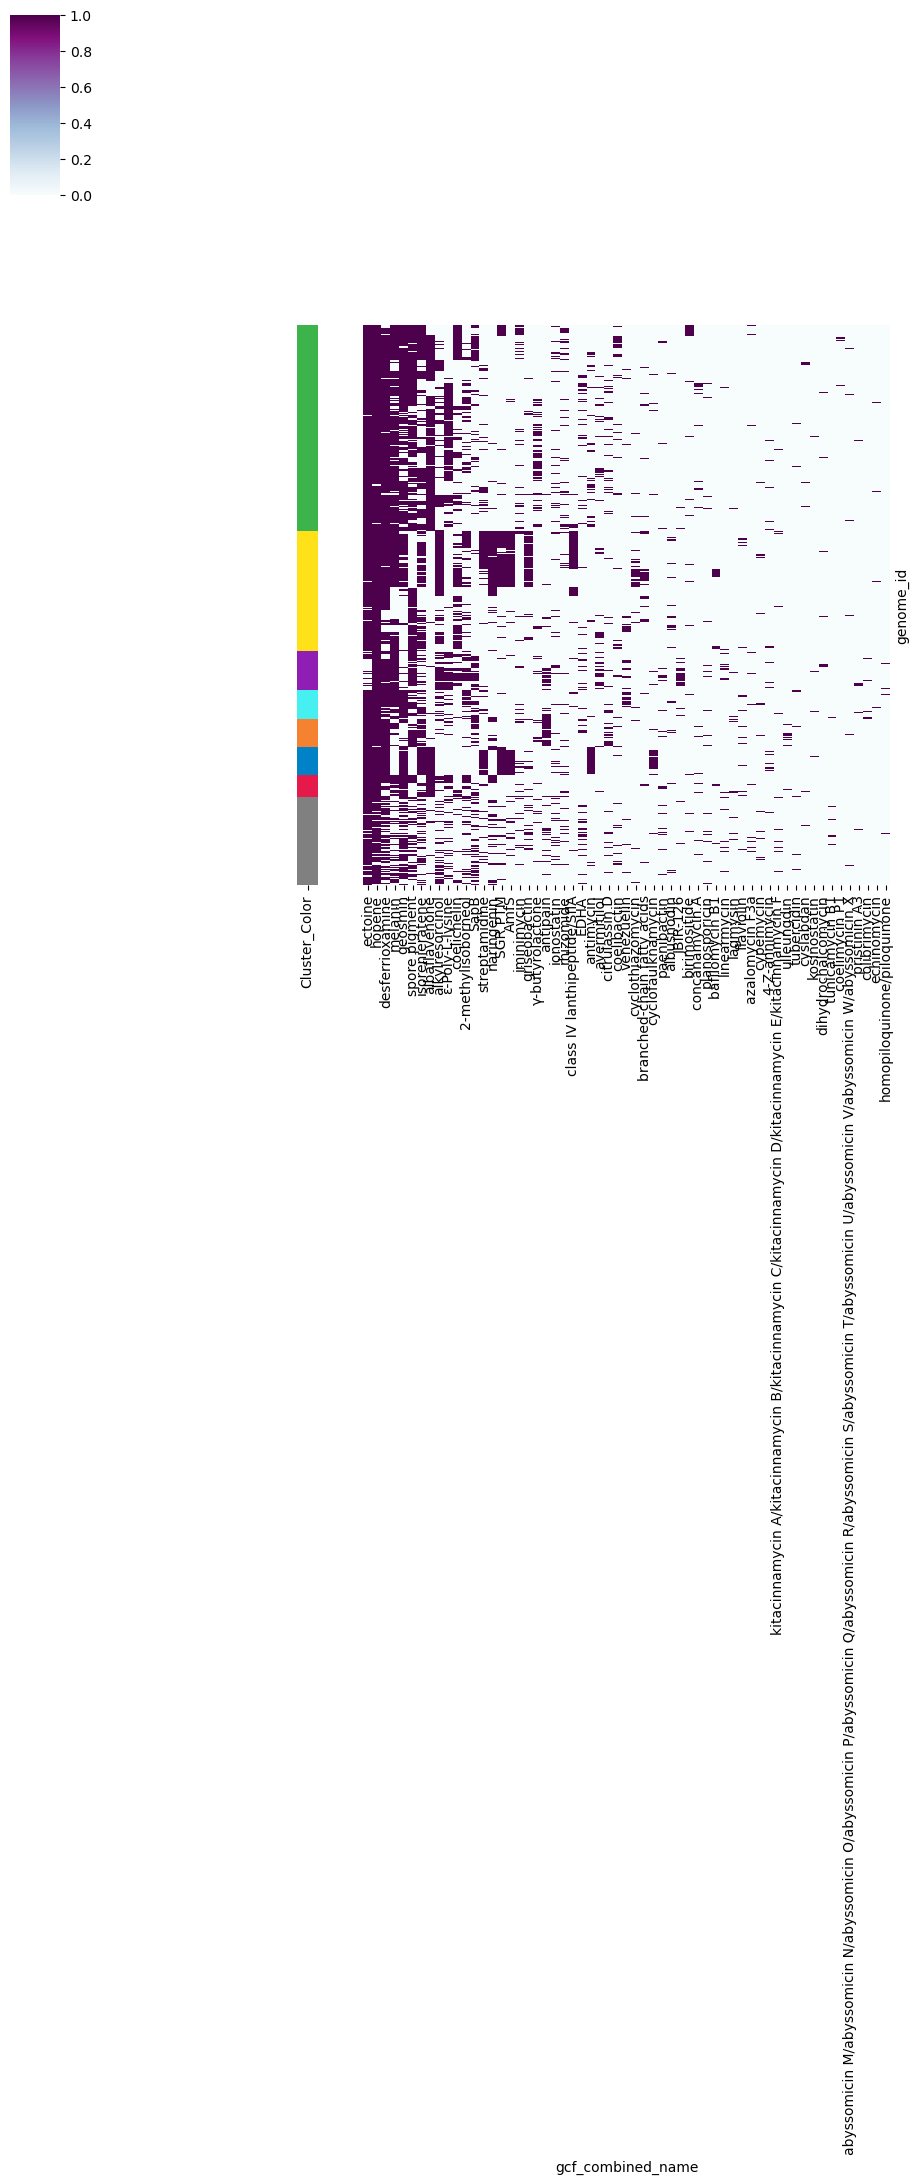

In [162]:
df_filtered = df_binary[df_binary.sum(axis=1) >= 6]
df_gcf_common = df_gcfs_bigslice_combined_known.loc[df_filtered.index,:]
df_gcf_presence_common = df_gcf_presence_combined.loc[:, df_gcf_common.index]

df_gcf_common = df_gcf_common.sort_values(by=["known", "bgc_count", "top_known_cluster_name"], ascending=False)

df_colors = df_clusters.loc[df_clusters.index,["Cluster_Color"]]
df_heatmap = df_gcf_presence_combined.loc[df_clusters.index, df_gcf_common.index]
df_heatmap = (df_heatmap > 0).astype(int) 
df_heatmap.columns = df_gcf_common.gcf_combined_name
plt.figure(figsize=(20,40))
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, row_cluster=False, col_cluster=False,
               xticklabels=True, yticklabels=False)
# plt.savefig("assets/figures/Figure_3/bigslice_present_common.png")

## Accessory GCFs present in 2 to 5 phylogroups (most significant intersections selected)

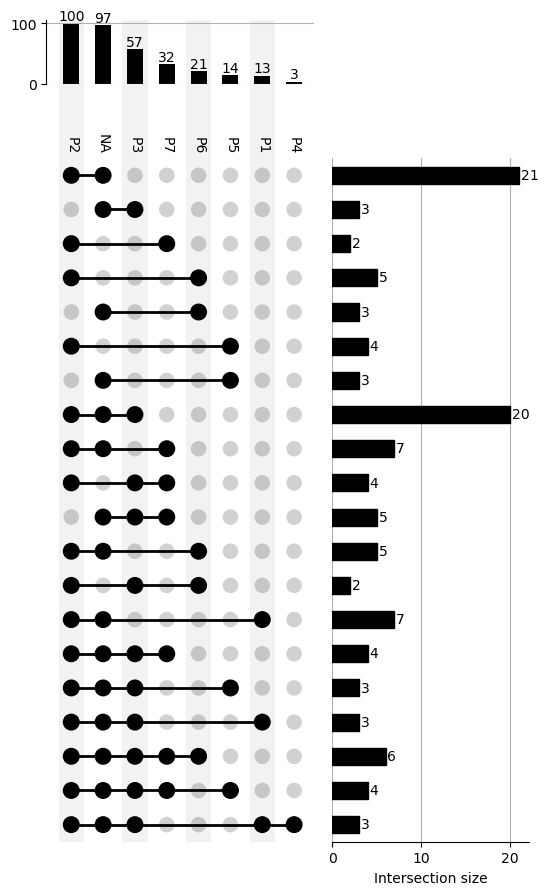

In [60]:
# Filter BGCs present in 2 to 6 groups and keep top n intersections 
df_filtered = df_binary[(df_binary.sum(axis=1) > 1) & (df_binary.sum(axis=1) < 6)]

# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_filtered.astype(bool)))

# Calculate the size of each intersection
intersection_counts = df_multi_index.groupby(level=list(range(df_multi_index.index.nlevels))).size()

# Sort by size and keep the top n intersections
n = 20
top_intersections = intersection_counts.nlargest(n).index

# Filter df_multi_index to only include top intersections
df_multi_index_filtered = df_multi_index[df_multi_index.index.isin(top_intersections)]

# This will sort by size of intersections and only show the top 10
ax = plot(df_multi_index_filtered, subset_size='count', show_counts=True, orientation="vertical")
# plt.savefig("assets/figures/upset_gcfs_2_6.svg")
# plt.savefig("assets/figures/upset_gcfs_2_6.png")
plt.show()

<Figure size 2000x4000 with 0 Axes>

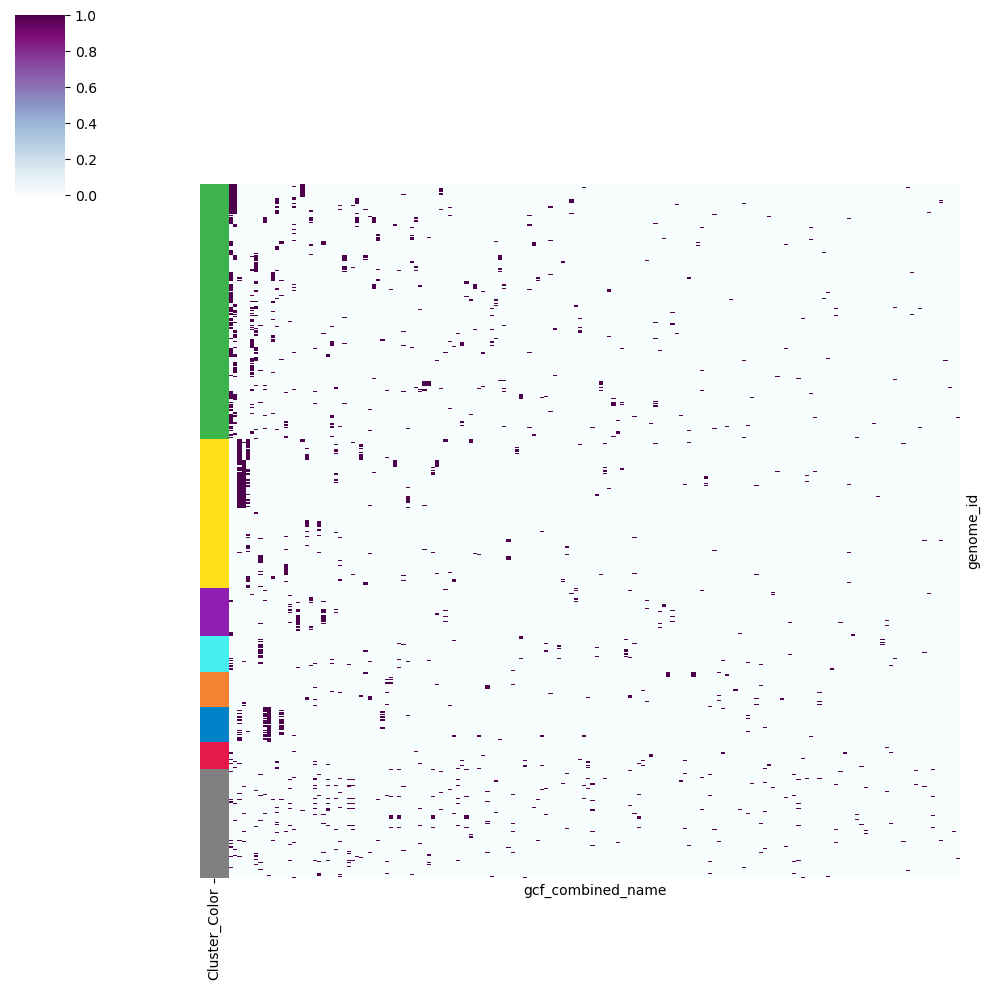

In [61]:
df_filtered = df_binary[(df_binary.sum(axis=1) > 1) & (df_binary.sum(axis=1) < 6)]

df_gcf_accessory = df_gcfs_bigslice_combined.loc[df_filtered.index,:]
df_gcf_presence_accessort = df_gcf_presence_combined.loc[:, df_gcf_accessory.index]

df_gcf_accessory = df_gcf_accessory.sort_values(by=["known", "bgc_count", "top_known_cluster_name"], ascending=False)

df_colors = df_clusters.loc[df_clusters.index,["Cluster_Color"]]
df_heatmap = df_gcf_presence_combined.loc[df_clusters.index, df_gcf_accessory.index]
df_heatmap = (df_heatmap > 0).astype(int) 
df_heatmap.columns = df_gcf_accessory.gcf_combined_name

plt.figure(figsize=(20,40))
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, row_cluster=False, col_cluster=False,
               xticklabels=False, yticklabels=False)
# plt.savefig("assets/figures/Figure_3/bigslice_present_accesory.png")

<Figure size 2000x4000 with 0 Axes>

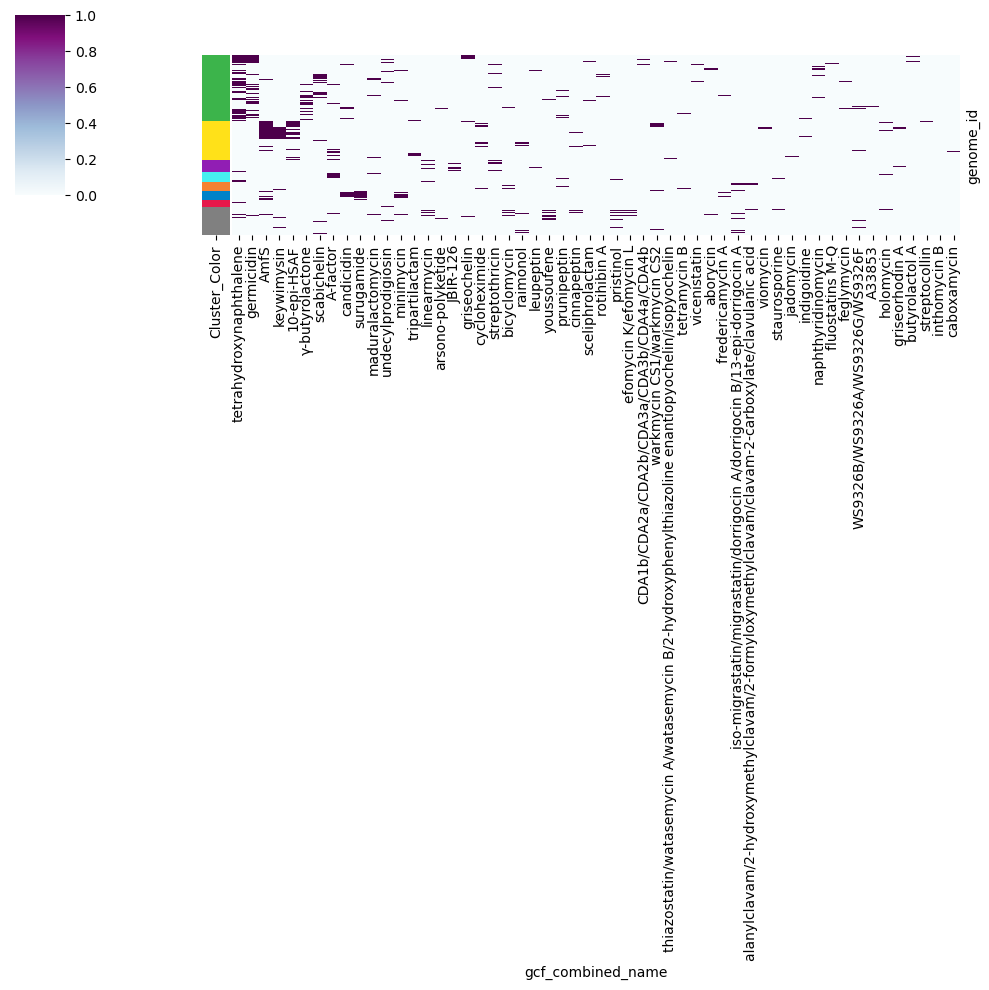

In [62]:
df_filtered = df_binary[(df_binary.sum(axis=1) > 1) & (df_binary.sum(axis=1) < 6)]

df_gcf_accessory = df_gcfs_bigslice_combined.loc[df_filtered.index,:]
df_gcf_accessory = df_gcf_accessory.sort_values(by=["known", "bgc_count", "top_known_cluster_name"], ascending=False)

df_colors = df_clusters.loc[df_clusters.index,["Cluster_Color"]]

# Reduce GCFs to those with more than 50 BGCs
df_gcf_accessory_red = df_gcf_accessory[df_gcf_accessory["bgc_count"] > 30]
df_heatmap = df_gcf_presence_combined.loc[df_clusters.index, df_gcf_accessory_red.index]
df_heatmap = (df_heatmap > 0).astype(int) 
df_heatmap.columns = df_gcf_accessory_red.gcf_combined_name
plt.figure(figsize=(20,40))
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, row_cluster=False, col_cluster=False,
               xticklabels=True, yticklabels=False)
# plt.savefig("assets/figures/Figure_3/bigslice_present_accesory_reduced.png")

## Unique GCFs present in 1 phylogroups

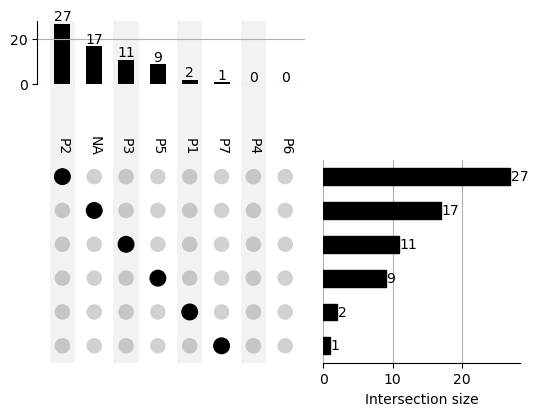

In [63]:
# Filter BGCs present in 2 to 6 groups and keep top n intersections 
df_filtered = df_binary[df_binary.sum(axis=1) == 1]

# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_filtered.astype(bool)))

# This will sort by size of intersections and only show the top 10
ax = plot(df_multi_index, subset_size='count', show_counts=True, orientation="vertical")
# plt.savefig("assets/figures/upset_gcfs_1.svg")
# plt.savefig("assets/figures/upset_gcfs_1.png")
plt.show()

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


<Figure size 2000x4000 with 0 Axes>

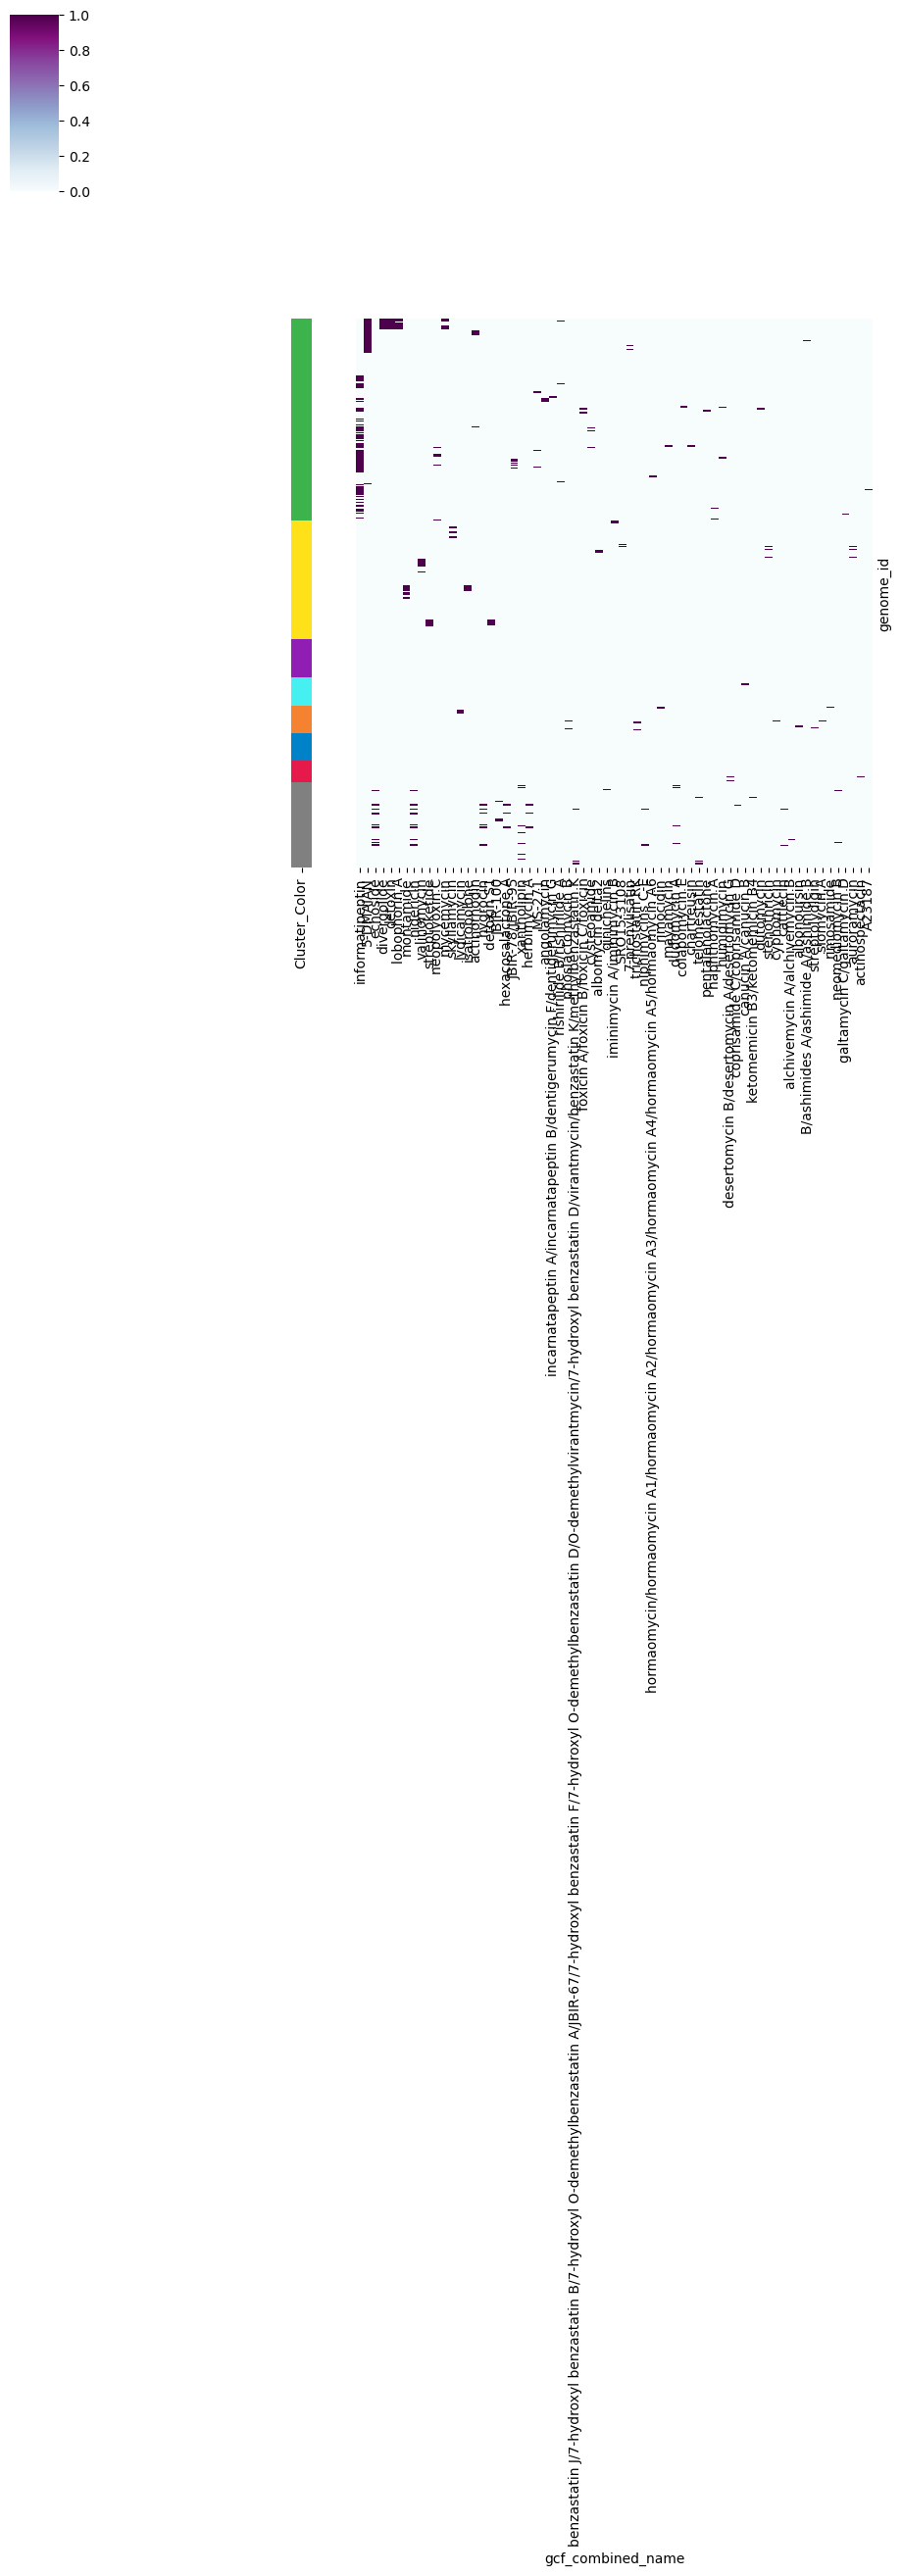

In [64]:
df_filtered = df_binary[df_binary.sum(axis=1) == 1]

df_gcf_unique = df_gcfs_bigslice_combined.loc[df_filtered.index,:]

df_gcf_unique = df_gcf_unique.sort_values(by=["known", "bgc_count", "top_known_cluster_name"], ascending=False)

df_colors = df_clusters.loc[df_clusters.index,["Cluster_Color"]]
df_heatmap = df_gcf_presence_combined.loc[df_clusters.index, df_gcf_unique.index]
df_heatmap = (df_heatmap > 0).astype(int) 
df_heatmap.columns = df_gcf_unique.gcf_combined_name
plt.figure(figsize=(20,40))
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, row_cluster=False, col_cluster=False,
               xticklabels=True, yticklabels=False)
# plt.savefig("assets/figures/Figure_3/bigslice_present_unique.png")

<Figure size 640x480 with 0 Axes>

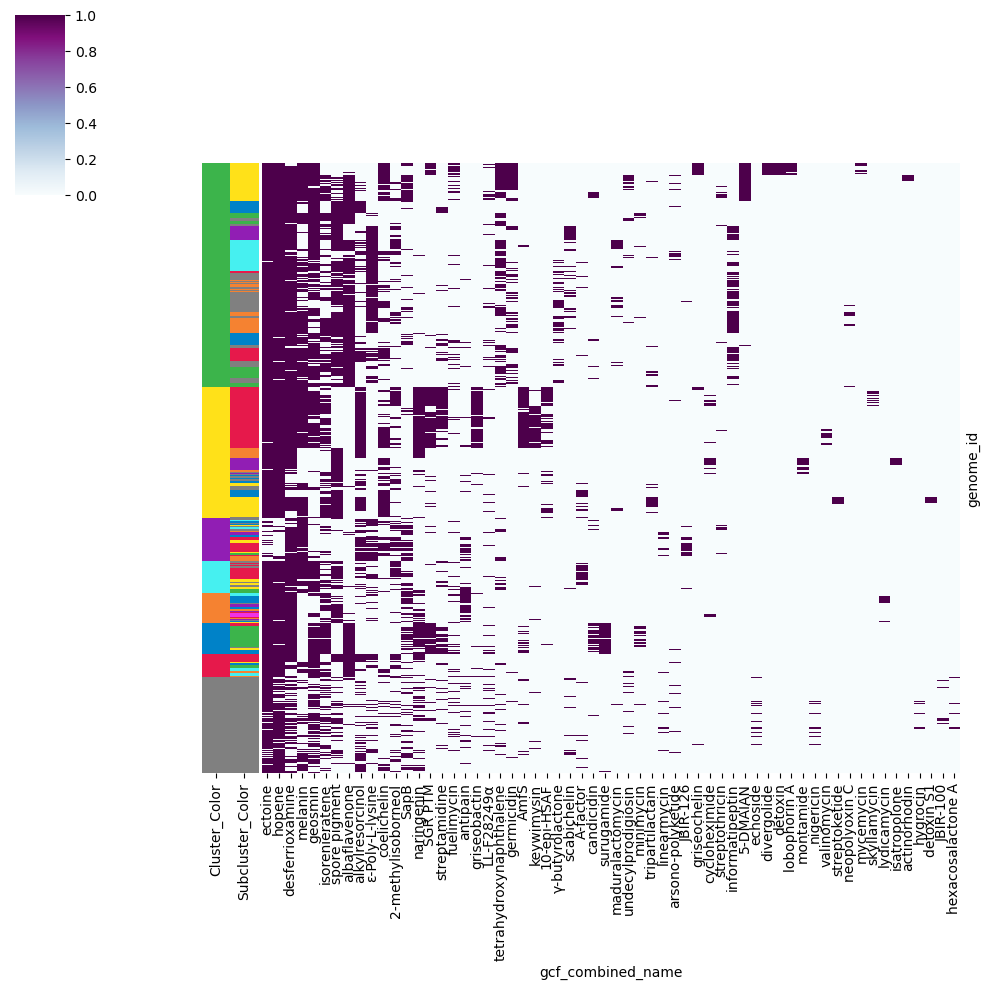

In [66]:
gcf_selected = df_gcf_common.index.tolist()[:20] + df_gcf_accessory.index.tolist()[:20] + df_gcf_unique.index.tolist()[:20]
df_gcf_selected = df_gcfs_bigslice_combined_known.loc[gcf_selected,:]
df_colors = df_clusters.loc[df_clusters.index,["Cluster_Color", "Subcluster_Color"]]
df_heatmap = df_gcf_presence_combined.loc[df_clusters.index, df_gcf_selected.index]
df_heatmap = (df_heatmap > 0).astype(int) 
df_heatmap.columns = df_gcf_selected.gcf_combined_name
plt.figure()
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, row_cluster=False, col_cluster=False,
               xticklabels=True, yticklabels=False)
plt.savefig("assets/figures/Figure_3/known_BGCs_selected_genomes.pdf")

In [67]:
df_gcfs_bigslice_combined_unknown = df_gcfs_bigslice_combined[df_gcfs_bigslice_combined.known == "Unknown"]
df_gcf_presence_combined = df_gcf_presence_combined_all.loc(df_clusters.index, df_gcfs_bigslice_combined_unknown.index)

/tmp/ipykernel_84879/4052653348.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Cluster_label.fillna("NA",inplace=True)


<Figure size 1500x1000 with 0 Axes>

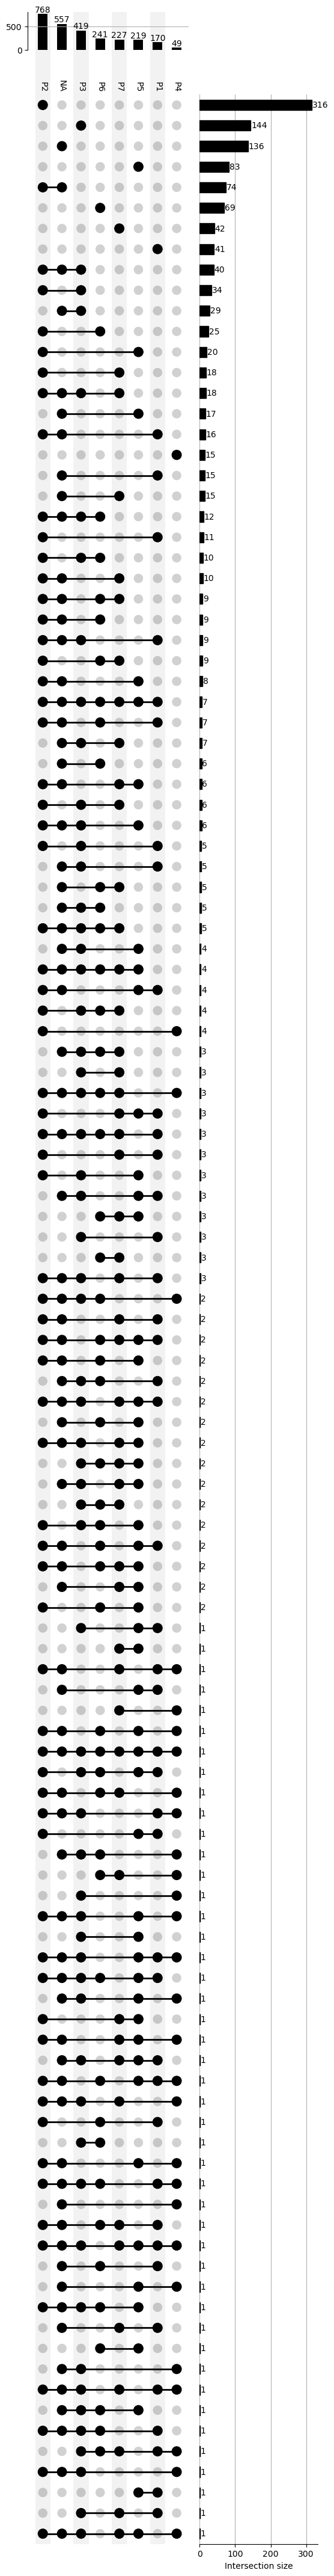

In [70]:
# Melt the dataframe
df_gcf_presence_tmp = df_gcf_presence_combined.loc[:, df_gcfs_bigslice_combined_unknown[df_gcfs_bigslice_combined_unknown["bgc_count"] > 5].index]
df_gcf_presence_tmp["genome_id"] = df_gcf_presence_tmp.index
df1 = df_gcf_presence_tmp.melt(id_vars=["genome_id"], value_vars=df_gcf_presence_tmp.columns[:-1],
                               var_name="BGC",
                               value_name="presence")
df2 = df_clusters[["Cluster_label"]]
df2.Cluster_label.fillna("NA",inplace=True)
# Merging dataframes
df = df1.merge(df2, on='genome_id')

# Creating a pivot table
pivot_table = df.pivot_table(index='BGC', columns='Cluster_label', values='presence', aggfunc='sum').fillna(0)

df_binary = (pivot_table > 0).astype(int)

# Convert the wide DataFrame to a long one
df_long = df_binary.reset_index().melt(id_vars='BGC', value_name='presence')
# Filter out entries where presence is 0
df_long = df_long[df_long.presence == 1]

# Create a boolean matrix representation
df_bool = pd.crosstab(df_long['BGC'], df_long['Cluster_label'])

# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_bool.astype(bool)))

# Manually set the colors
plt.figure(figsize=(15, 10))

ax = plot(df_multi_index, subset_size='count', sort_by="cardinality", show_counts=True, orientation="vertical")
# plt.savefig("assets/figures/upset_gcfs.svg")
# plt.savefig("assets/figures/upset_gcfs.png")
plt.show()

## Common GCF spread across 6 or more phylogroups

<Figure size 1500x1000 with 0 Axes>

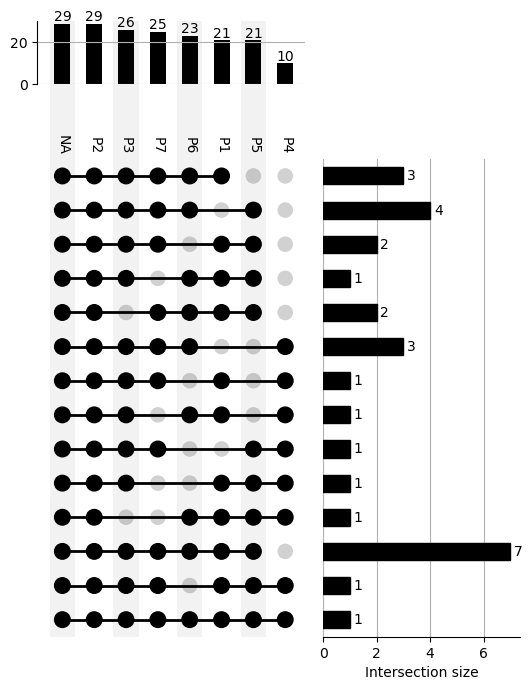

In [71]:
# Filter rows that are present in more than 6 groups
df_filtered = df_binary[df_binary.sum(axis=1) >= 6]


# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_filtered.astype(bool)))

# Manually set the colors
plt.figure(figsize=(15, 10))

ax = plot(df_multi_index, subset_size='count', show_counts=True, orientation="vertical")
# plt.savefig("assets/figures/upset_gcfs_6_and_above.svg")
# plt.savefig("assets/figures/upset_gcfs_6_and_above.png")
plt.show()

<Figure size 2000x4000 with 0 Axes>

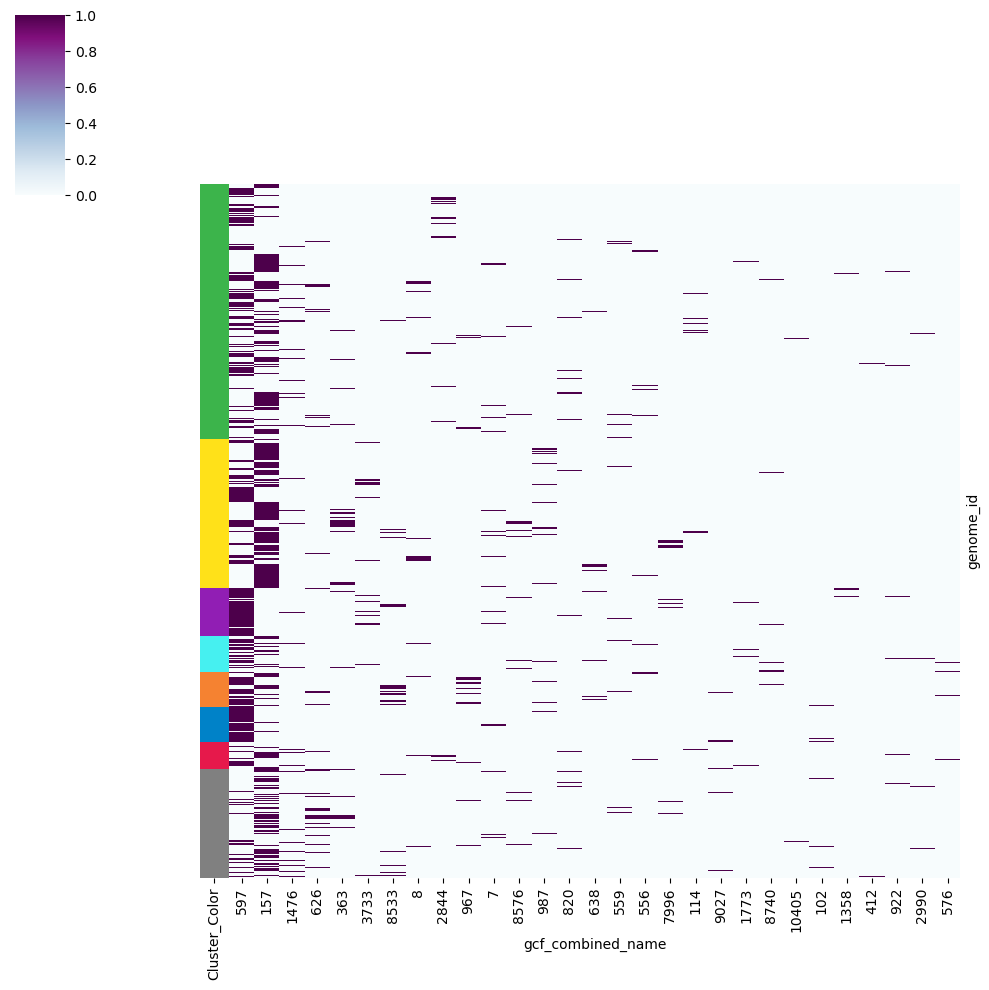

In [72]:
df_filtered = df_binary[df_binary.sum(axis=1) >= 6]
df_gcf_common = df_gcfs_bigslice_combined_unknown.loc[df_filtered.index,:]
df_gcf_presence_common = df_gcf_presence_combined.loc[:, df_gcf_common.index]

df_gcf_common = df_gcf_common.sort_values(by=["known", "bgc_count", "top_known_cluster_name"], ascending=False)

df_colors = df_clusters.loc[df_clusters.index,["Cluster_Color"]]
df_heatmap = df_gcf_presence_combined.loc[df_clusters.index, df_gcf_common.index]
df_heatmap = (df_heatmap > 0).astype(int) 
df_heatmap.columns = df_gcf_common.gcf_combined_name
plt.figure(figsize=(20,40))
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, row_cluster=False, col_cluster=False,
               xticklabels=True, yticklabels=False)
# plt.savefig("assets/figures/Figure_3/bigslice_present_common.png")

## Accessory GCFs present in 2 to 5 phylogroups (most significant intersections selected)

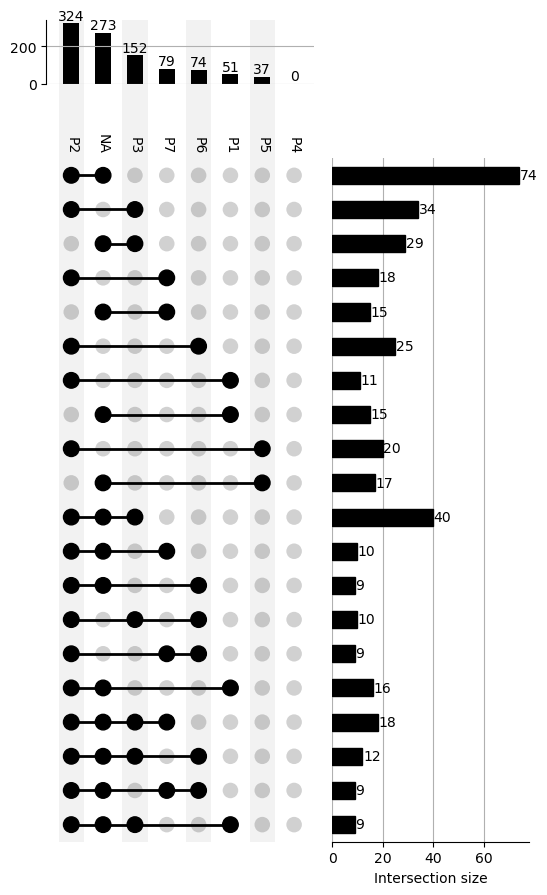

In [73]:
# Filter BGCs present in 2 to 6 groups and keep top n intersections 
df_filtered = df_binary[(df_binary.sum(axis=1) > 1) & (df_binary.sum(axis=1) < 6)]

# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_filtered.astype(bool)))

# Calculate the size of each intersection
intersection_counts = df_multi_index.groupby(level=list(range(df_multi_index.index.nlevels))).size()

# Sort by size and keep the top n intersections
n = 20
top_intersections = intersection_counts.nlargest(n).index

# Filter df_multi_index to only include top intersections
df_multi_index_filtered = df_multi_index[df_multi_index.index.isin(top_intersections)]

# This will sort by size of intersections and only show the top 10
ax = plot(df_multi_index_filtered, subset_size='count', show_counts=True, orientation="vertical")
# plt.savefig("assets/figures/upset_gcfs_2_6.svg")
# plt.savefig("assets/figures/upset_gcfs_2_6.png")
plt.show()

<Figure size 2000x4000 with 0 Axes>

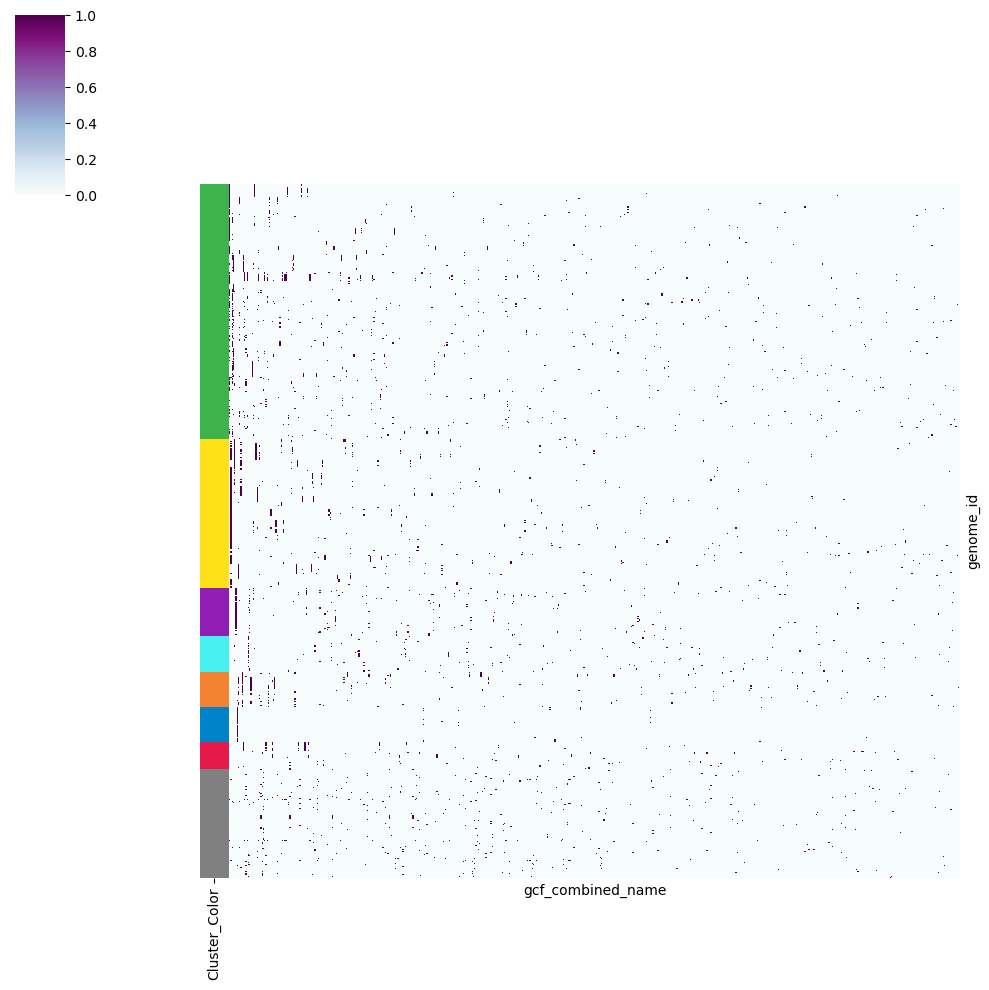

In [74]:
df_filtered = df_binary[(df_binary.sum(axis=1) > 1) & (df_binary.sum(axis=1) < 6)]

df_gcf_accessory = df_gcfs_bigslice_combined.loc[df_filtered.index,:]
df_gcf_presence_accessort = df_gcf_presence_combined.loc[:, df_gcf_accessory.index]

df_gcf_accessory = df_gcf_accessory.sort_values(by=["known", "bgc_count", "top_known_cluster_name"], ascending=False)

df_colors = df_clusters.loc[df_clusters.index,["Cluster_Color"]]
df_heatmap = df_gcf_presence_combined.loc[df_clusters.index, df_gcf_accessory.index]
df_heatmap = (df_heatmap > 0).astype(int) 
df_heatmap.columns = df_gcf_accessory.gcf_combined_name

plt.figure(figsize=(20,40))
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, row_cluster=False, col_cluster=False,
               xticklabels=False, yticklabels=False)
# plt.savefig("assets/figures/Figure_3/bigslice_present_accesory.png")

<Figure size 2000x4000 with 0 Axes>

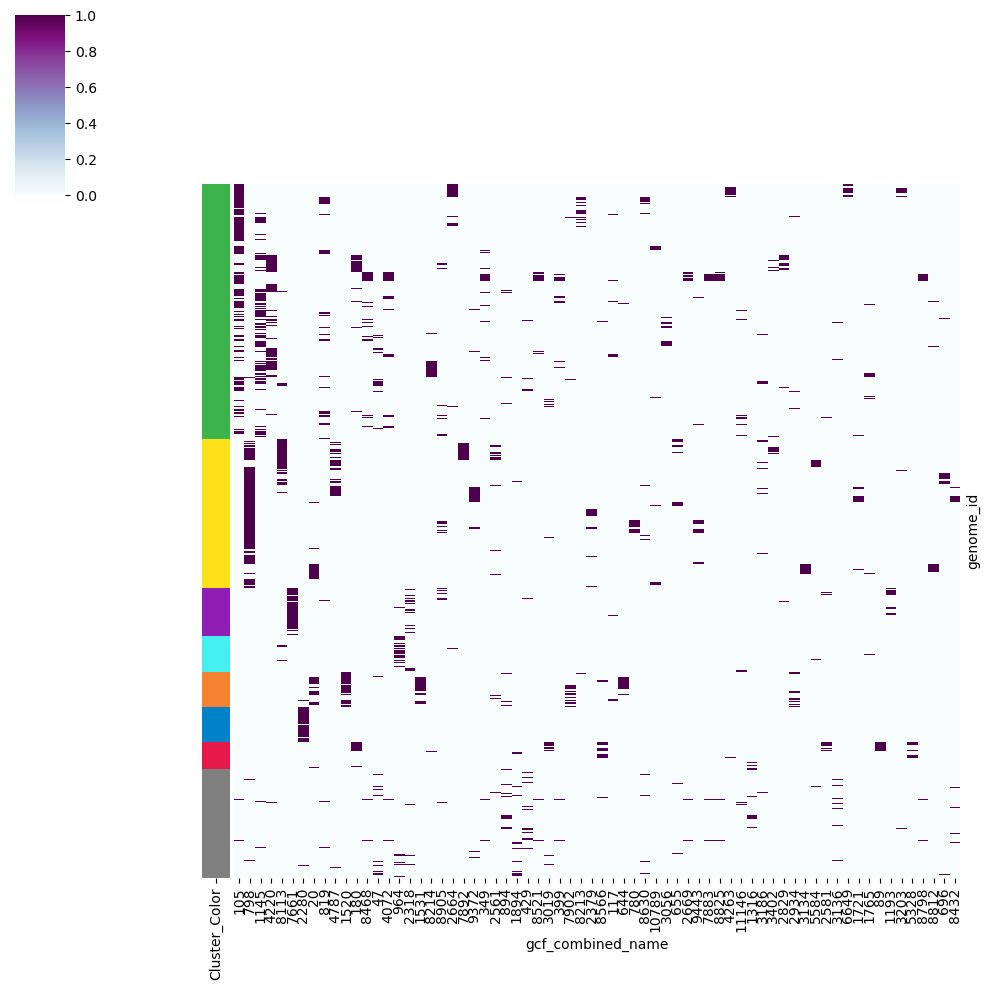

In [75]:
df_filtered = df_binary[(df_binary.sum(axis=1) > 1) & (df_binary.sum(axis=1) < 6)]

df_gcf_accessory = df_gcfs_bigslice_combined.loc[df_filtered.index,:]
df_gcf_accessory = df_gcf_accessory.sort_values(by=["known", "bgc_count", "top_known_cluster_name"], ascending=False)

df_colors = df_clusters.loc[df_clusters.index,["Cluster_Color"]]

# Reduce GCFs to those with more than 50 BGCs
df_gcf_accessory_red = df_gcf_accessory[df_gcf_accessory["bgc_count"] > 30]
df_heatmap = df_gcf_presence_combined.loc[df_clusters.index, df_gcf_accessory_red.index]
df_heatmap = (df_heatmap > 0).astype(int) 
df_heatmap.columns = df_gcf_accessory_red.gcf_combined_name
plt.figure(figsize=(20,40))
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, row_cluster=False, col_cluster=False,
               xticklabels=True, yticklabels=False)
# plt.savefig("assets/figures/Figure_3/bigslice_present_accesory_reduced.png")

## Unique GCFs present in 1 phylogroups

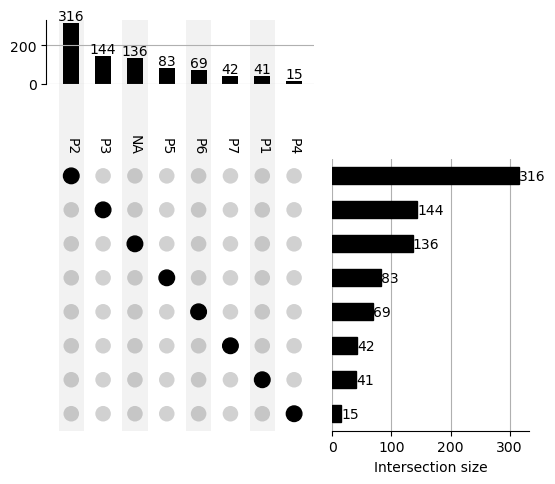

In [76]:
# Filter BGCs present in 2 to 6 groups and keep top n intersections 
df_filtered = df_binary[df_binary.sum(axis=1) == 1]

# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_filtered.astype(bool)))

# This will sort by size of intersections and only show the top 10
ax = plot(df_multi_index, subset_size='count', show_counts=True, orientation="vertical")
# plt.savefig("assets/figures/upset_gcfs_1.svg")
# plt.savefig("assets/figures/upset_gcfs_1.png")
plt.show()

<Figure size 2000x4000 with 0 Axes>

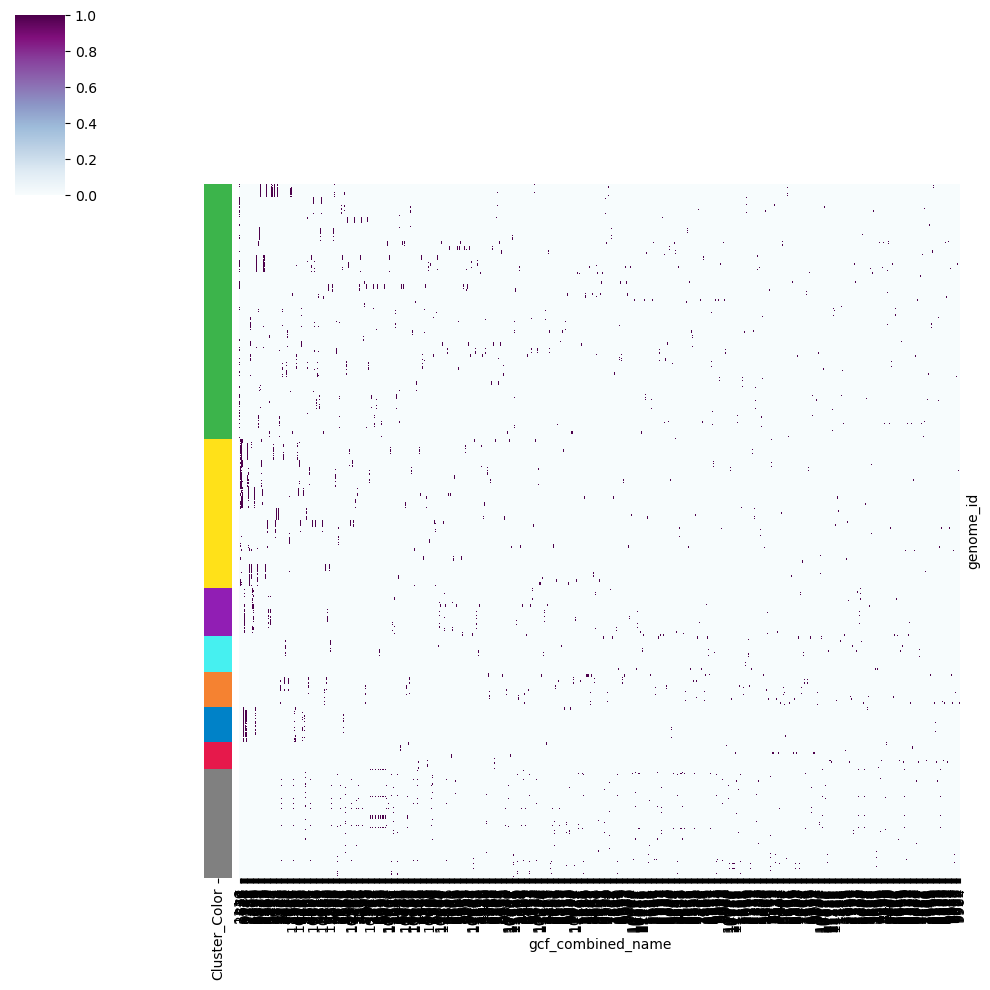

In [77]:
df_filtered = df_binary[df_binary.sum(axis=1) == 1]

df_gcf_unique = df_gcfs_bigslice_combined.loc[df_filtered.index,:]

df_gcf_unique = df_gcf_unique.sort_values(by=["known", "bgc_count", "top_known_cluster_name"], ascending=False)

df_colors = df_clusters.loc[df_clusters.index,["Cluster_Color"]]
df_heatmap = df_gcf_presence_combined.loc[df_clusters.index, df_gcf_unique.index]
df_heatmap = (df_heatmap > 0).astype(int) 
df_heatmap.columns = df_gcf_unique.gcf_combined_name
plt.figure(figsize=(20,40))
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, row_cluster=False, col_cluster=False,
               xticklabels=True, yticklabels=False)
# plt.savefig("assets/figures/Figure_3/bigslice_present_unique.png")

In [78]:
print(df_gcf_common.shape[0])
print(df_gcf_accessory.shape[0])
print(df_gcf_unique.shape[0])

29
582
846


<Figure size 640x480 with 0 Axes>

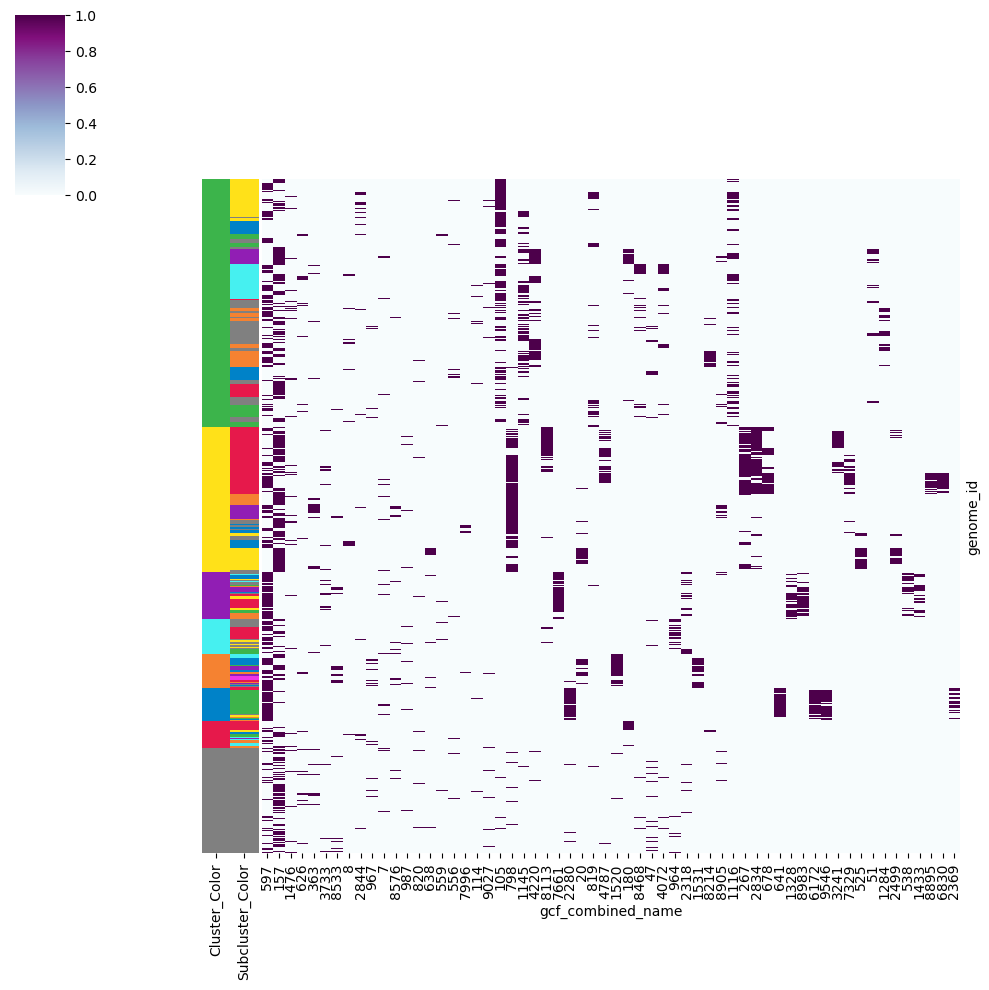

In [79]:
gcf_selected = df_gcf_common.index.tolist()[:20] + df_gcf_accessory.index.tolist()[:20] + df_gcf_unique.index.tolist()[:20]
df_gcf_selected = df_gcfs_bigslice_combined_unknown.loc[gcf_selected,:]
df_colors = df_clusters.loc[df_clusters.index,["Cluster_Color", "Subcluster_Color"]]
df_heatmap = df_gcf_presence_combined.loc[df_clusters.index, df_gcf_selected.index]
df_heatmap = (df_heatmap > 0).astype(int) 
df_heatmap.columns = df_gcf_selected.gcf_combined_name
plt.figure()
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, row_cluster=False, col_cluster=False,
               xticklabels=True, yticklabels=False)
plt.savefig("assets/figures/Figure_3/unknown_BGCs_selected_genomes.pdf")

# All GCFs plots

In [81]:
df_gcf_presence_combined = df_gcf_presence_combined_all.copy()

/tmp/ipykernel_84879/1288785474.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Cluster_label.fillna("NA",inplace=True)


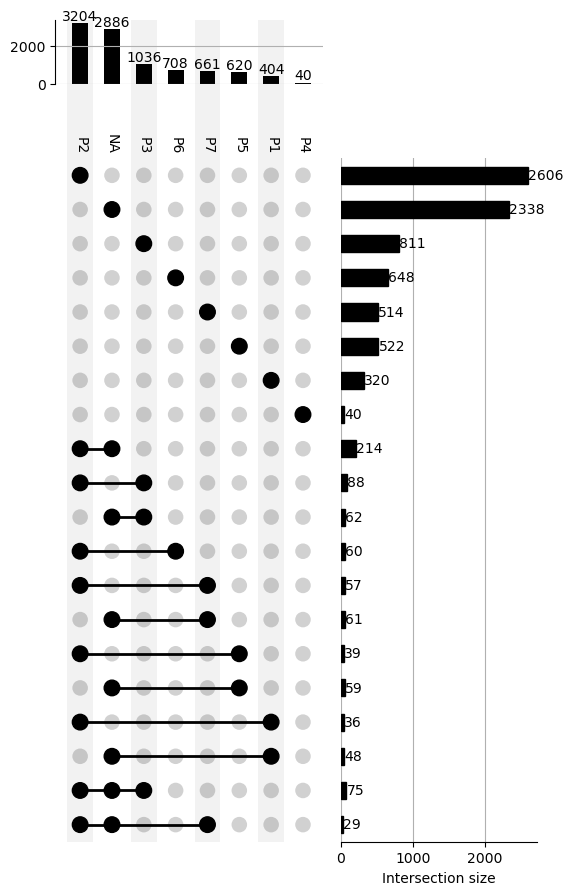

In [82]:
# Melt the dataframe
df_gcf_presence_tmp = df_gcf_presence_combined.copy()
df_gcf_presence_tmp["genome_id"] = df_gcf_presence_tmp.index
df1 = df_gcf_presence_tmp.melt(id_vars=["genome_id"], value_vars=df_gcf_presence_tmp.columns[:-1],
                               var_name="BGC",
                               value_name="presence")
df2 = df_clusters[["Cluster_label"]]
df2.Cluster_label.fillna("NA",inplace=True)
# Merging dataframes
df = df1.merge(df2, on='genome_id')

# Creating a pivot table
pivot_table = df.pivot_table(index='BGC', columns='Cluster_label', values='presence', aggfunc='sum').fillna(0)

df_binary = (pivot_table > 0).astype(int)

# Convert the wide DataFrame to a long one
df_long = df_binary.reset_index().melt(id_vars='BGC', value_name='presence')
# Filter out entries where presence is 0
df_long = df_long[df_long.presence == 1]

# Create a boolean matrix representation
df_bool = pd.crosstab(df_long['BGC'], df_long['Cluster_label'])

# Convert this DataFrame to a MultiIndex of boolean values
df_multi_index = pd.DataFrame(index=pd.MultiIndex.from_frame(df_bool.astype(bool)))


# Calculate the size of each intersection
intersection_counts = df_multi_index.groupby(level=list(range(df_multi_index.index.nlevels))).size()

# Sort by size and keep the top n intersections
n = 20
top_intersections = intersection_counts.nlargest(n).index

# Filter df_multi_index to only include top intersections
df_multi_index_filtered = df_multi_index[df_multi_index.index.isin(top_intersections)]

# This will sort by size of intersections and only show the top 10
ax = plot(df_multi_index_filtered, subset_size='count', show_counts=True, orientation="vertical")
# plt.savefig("assets/figures/upset_gcfs_2_6.svg")
plt.savefig("assets/figures/upset_gcfs_top_20.png")
plt.show()